In [1]:
import geopandas as gpd
import os
from sqlalchemy import create_engine

In [2]:
engine = create_engine(   
"mssql+pyodbc:///?odbc_connect="
"Driver%3D%7BODBC+Driver+17+for+SQL+Server%7D%3B"
"Server%3Drliddb.int.lcog.org%2C5433%3B"
"Database%3DRLIDGeo%3B"
"Trusted_Connection%3Dyes%3B"
"ApplicationIntent%3DReadWrite%3B"
"WSID%3Dclwrk4087.int.lcog.org%3B")

In [3]:
sql = '''
SELECT 
bike_segid AS id,
name,
ftypedes AS type,
status,
source,
Shape.STAsBinary() AS geom
FROM dbo.BikeFacility;
'''

In [4]:
bikeways = gpd.GeoDataFrame.from_postgis(sql, engine, geom_col='geom')

In [5]:
bikeways.head()

,id,name,type,status,source,geom
0,742,None,None,Built,SPR,"LINESTRING (4263801.473 881227.159, 4263975.97..."
1,951,None,None,Built,SPR,"LINESTRING (4256230.266 888843.222, 4256258.02..."
2,993,None,None,Built,SPR,"LINESTRING (4256392.263 889889.373, 4256435.45..."
3,3203,None,None,None,None,"LINESTRING (4264078.184 885097.225, 4264071.27..."
4,1,None,Paved Shoulder,Built,LCOG,"LINESTRING (4216611.495 857908.927, 4216569.84..."


In [6]:
bikeways.columns

Index(['id', 'name', 'type', 'status', 'source', 'geom'], dtype='object')

In [7]:
bikeways['status'].unique()

array(['Built', None, 'Future'], dtype=object)

In [8]:
bikeways['type'].unique()

array([None, 'Paved Shoulder', 'Bike Route',
       'Pedestrian and Bicycle Access Way', 'Bike Lane',
       'Shared Use Path', 'Neighborhood Greenway', 'Sidewalk',
       'Connectivity for Routing'], dtype=object)

In [9]:
bikeways[bikeways['status'] == 'Future']['type'].unique()

array(['Bike Lane', 'Shared Use Path',
       'Pedestrian and Bicycle Access Way', 'Bike Route'], dtype=object)

In [10]:
bikeways = bikeways[bikeways['status'] != 'Future']

In [3]:
outpath = r'T:\MPO\RTP\FY20 2045 Update\Data and Resources\PerformanceAnalysis\sidewalk_bikeway_trails'

In [12]:
bikeways.crs = "EPSG:2914"

In [13]:
bikeways = bikeways.to_crs(epsg=3857)

In [14]:
bikeways.to_file(os.path.join(outpath, "bikeways.shp"))

In [15]:
bikeways.head()

,id,name,type,status,source,geom
0,742,None,None,Built,SPR,"LINESTRING (-13692434.516 5474362.318, -136923..."
1,951,None,None,Built,SPR,"LINESTRING (-13695736.452 5477500.916, -136957..."
2,993,None,None,Built,SPR,"LINESTRING (-13695681.251 5477947.477, -136956..."
3,3203,None,None,None,None,"LINESTRING (-13692366.321 5476009.686, -136923..."
4,1,None,Paved Shoulder,Built,LCOG,"LINESTRING (-13712090.803 5463844.762, -137121..."


In [16]:
import matplotlib.pyplot as plt
import contextily as ctx

In [17]:
MPObd = gpd.read_file("V:/Data/Transportation/MPO_Bound.shp")

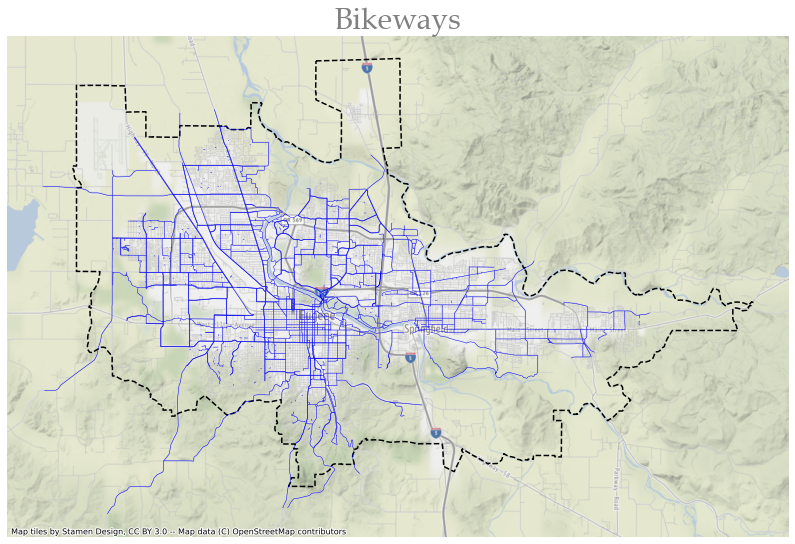

In [18]:
fig, ax = plt.subplots(figsize=(14, 12))
bikeways.plot(ax=ax, color='blue', linewidth = 0.5, aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', linewidth = 1.5, aspect=1)
ctx.add_basemap(ax, alpha = 0.7)
plt.title("Bikeways", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [1]:
import arcpy, os

In [5]:
from arcpy import env
env.overwriteOutput = True

In [6]:
arcpy.analysis.Clip(os.path.join(outpath, "bikeways.shp"), 
                    "V:/Data/Transportation/MPO_Bound.shp", 
                    os.path.join(outpath, "bikeways_EUG_SPR.shp"))

<Result 'T:\\MPO\\RTP\\FY20 2045 Update\\Data and Resources\\PerformanceAnalysis\\sidewalk_bikeway_trails\\bikeways_EUG_SPR.shp'>

In [20]:
bikeways_EUG_SPR = gpd.read_file(os.path.join(outpath, "bikeways_EUG_SPR.shp"))

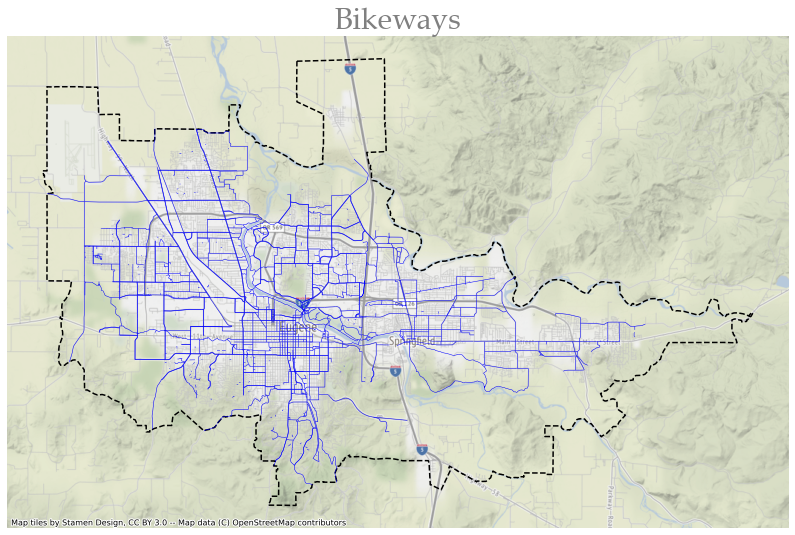

In [21]:
fig, ax = plt.subplots(figsize=(14, 12))
bikeways_EUG_SPR.plot(ax=ax, color='blue', linewidth = 0.5, aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', linewidth = 1.5, aspect=1)
ctx.add_basemap(ax, alpha = 0.7)
plt.title("Bikeways", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [22]:
import numpy as np

In [23]:
bikeways_EUG_SPR['id'] = list(range(1,  bikeways_EUG_SPR.shape[0]+1, 1))
bikeways_EUG_SPR.rename(columns = {'id': 'Id'}, inplace =True)

In [24]:
path = r"T:\MPO\RTP\FY20 2045 Update\Data and Resources\Data\Coburg"

In [25]:
bikewaysCOB = gpd.read_file(os.path.join(path, "Coburg_bikelanes.shp"))

In [26]:
max(bikeways_EUG_SPR['Id'])

3010

In [27]:
bikewaysCOB['Id'] = list(range(max(bikeways_EUG_SPR['Id'])+1,  bikewaysCOB.shape[0] + max(bikeways_EUG_SPR['Id'] + 1), 1))

In [28]:
bikewaysCOB = bikewaysCOB.to_crs(epsg = 3857)

In [29]:
bikeways_EUG_SPR.rename(columns = {'geom': 'geometry'}, inplace =True)

In [30]:
bikeways_MPO = bikeways_EUG_SPR[['Id', 'geometry']].append(bikewaysCOB[['Id', 'geometry']])

In [31]:
type(bikeways_MPO)

geopandas.geodataframe.GeoDataFrame

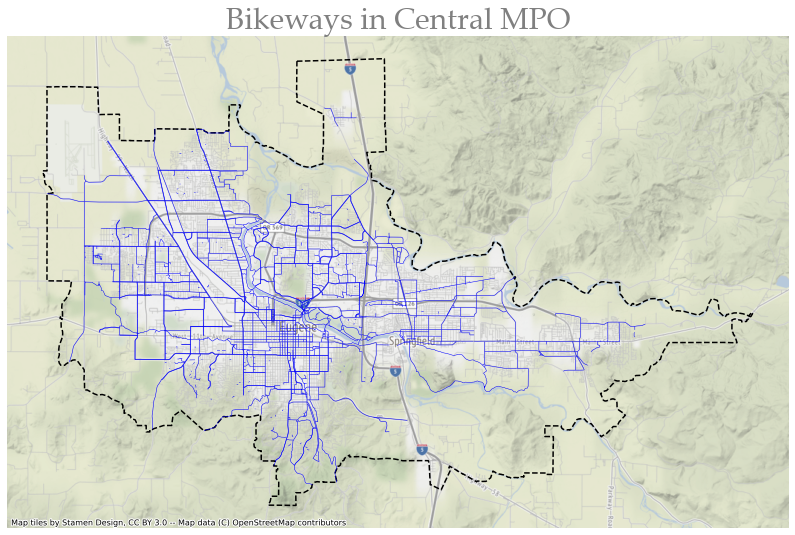

In [32]:
fig, ax = plt.subplots(figsize=(14, 12))
bikeways_MPO.plot(ax=ax, color='blue', linewidth = 0.5, aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', linewidth = 1.5, aspect=1)
ctx.add_basemap(ax, alpha = 0.7)
plt.title("Bikeways in Central MPO", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [33]:
bikeways_MPO.to_file(os.path.join(outpath, 'Bikeways_MPO.shp'))

In [34]:
bikeways_EUG_SPR.head()

,Id,name,type,status,source,geometry
0,1,None,None,Built,SPR,"LINESTRING (-13692434.516 5474362.318, -136923..."
1,2,None,None,Built,SPR,"LINESTRING (-13695736.452 5477500.916, -136957..."
2,3,None,None,Built,SPR,"LINESTRING (-13695681.251 5477947.477, -136956..."
3,4,None,None,None,None,"LINESTRING (-13692366.321 5476009.686, -136923..."
4,5,Fox Hollow,Bike Route,Built,LCOG,"LINESTRING (-13701993.554 5464175.914, -137019..."


In [35]:
bikeways_EUG_SPR['type'].unique()

array([None, 'Bike Route', 'Paved Shoulder',
       'Pedestrian and Bicycle Access Way', 'Bike Lane',
       'Shared Use Path', 'Neighborhood Greenway', 'Sidewalk',
       'Connectivity for Routing'], dtype=object)

In [36]:
SharedUsePath = bikeways_EUG_SPR[bikeways_EUG_SPR['type'] == 'Shared Use Path']

In [37]:
SharedUsePath_MPO = SharedUsePath[['Id', 'geometry']].append(bikewaysCOB[['Id', 'geometry']])

In [38]:
cobpath = r"T:\MPO\RTP\FY20 2045 Update\Data and Resources\Data\Coburg"

In [39]:
newpaths = gpd.read_file(os.path.join(cobpath, "NewHardSurfacePaths.shp"))

In [47]:
newpaths = newpaths.to_crs(epsg=3857)

In [48]:
SharedUsePath_MPO_updated = SharedUsePath_MPO.append(newpaths[newpaths.Notes != 'Sidewalk'][['Id', 'geometry']])

In [50]:
SharedUsePath_MPO_updated.to_file(os.path.join(outpath, 'SharedUsePath_MPO.shp'))

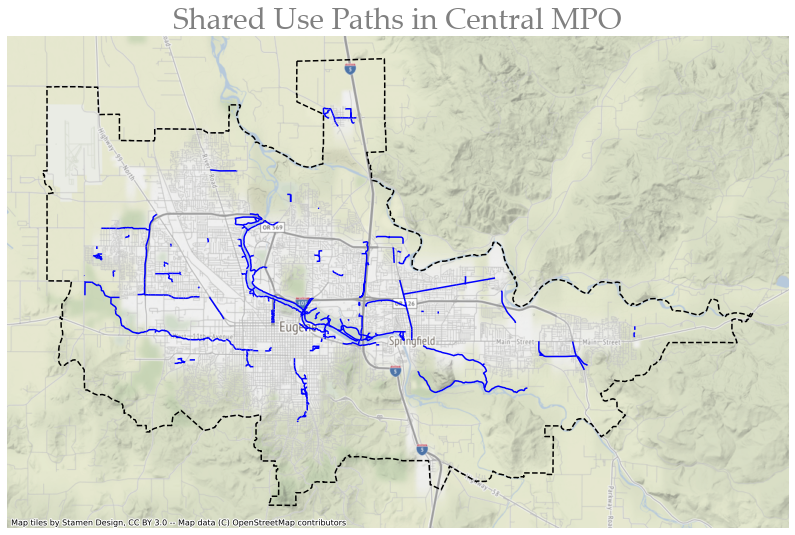

In [52]:
fig, ax = plt.subplots(figsize=(14, 12))
SharedUsePath_MPO_updated.plot(ax=ax, color='blue', aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', linewidth = 1.5, aspect=1)
ctx.add_basemap(ax, alpha = 0.7)
plt.title("Shared Use Paths in Central MPO", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");